In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Helper functions
def plot_images(image1, image2, title1, title2, fontsize=12):
    """
    Plot two images side by side
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=fontsize)
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=fontsize)
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.tight_layout()

In [3]:
# Chessboard size
nx = 9
ny = 6

In [4]:
def calibrate_camera(cal_images_path='camera_cal/calibration*.jpg', show_images=False, warnings=False):
    """
    Calibrate the camera using calibration images found in 'cal_images_path'.
    Return the camera matrix and the distortion coefficients.
    """
    objpoints, imgpoints = [], []
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    calibration_images = glob.glob(cal_images_path)
    print('Calibration images: {}'.format(len(calibration_images)))
    for filename in calibration_images:
        image = mpimg.imread(filename)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            if show_images == True:
                image = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
                plt.figure(figsize=(6, 3))
                plt.xticks([])
                plt.yticks([])
                plt.imshow(image)
                plt.tight_layout()
                
        if ret == False and warnings == True:
            print('No corners found for: {}'.format(filename))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_image.shape[::-1], None, None)
    
    return mtx, dist

In [5]:
# Camera calibration
mtx, dist = calibrate_camera()
print('Calibration complete')

Calibration images: 20
Calibration complete


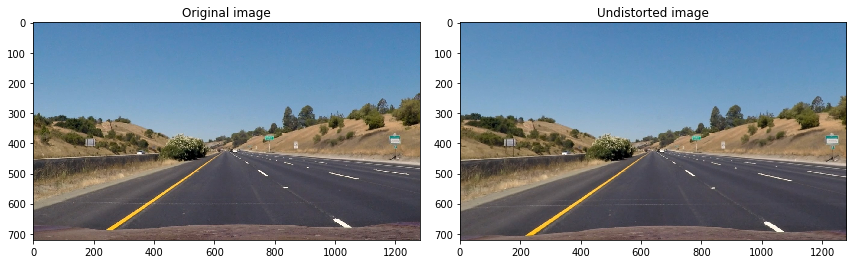

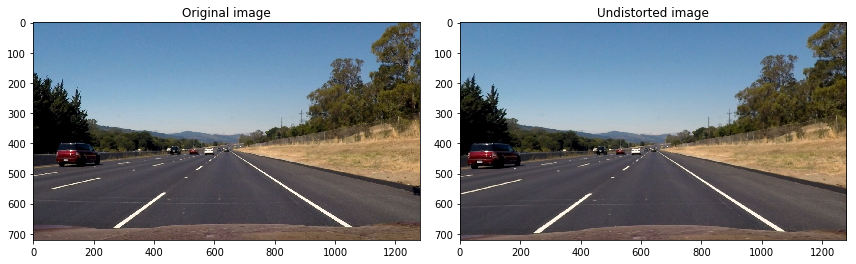

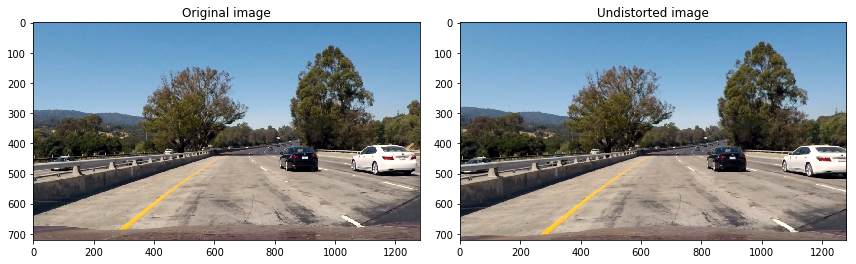

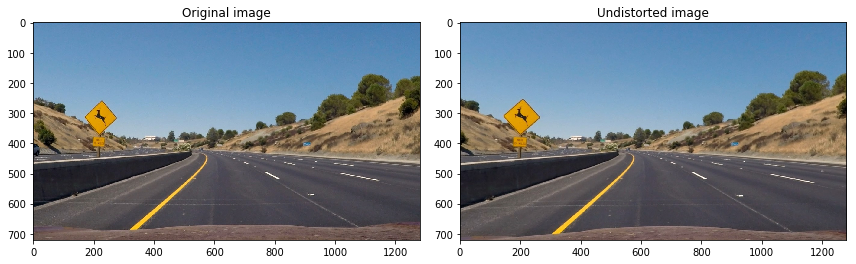

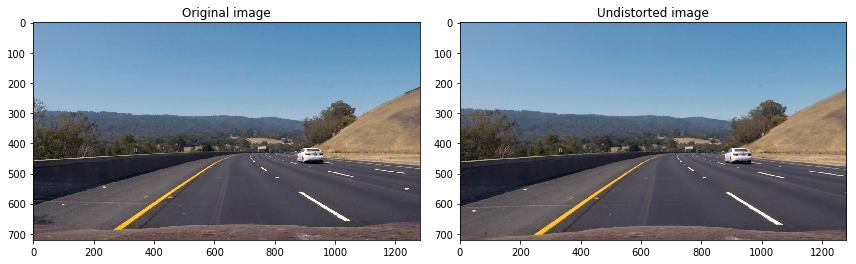

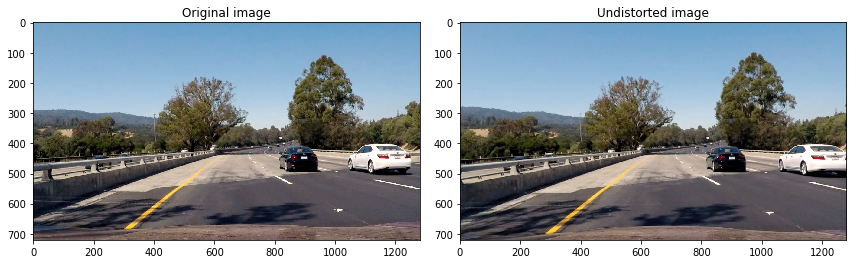

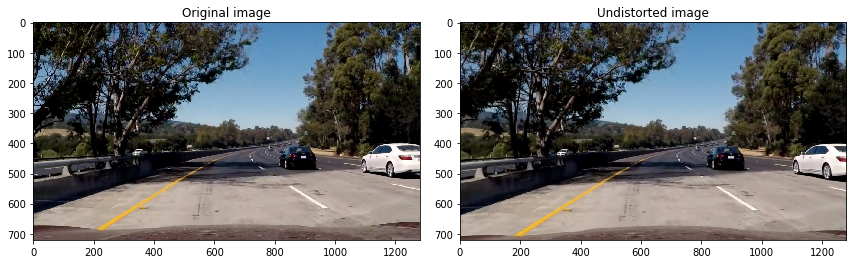

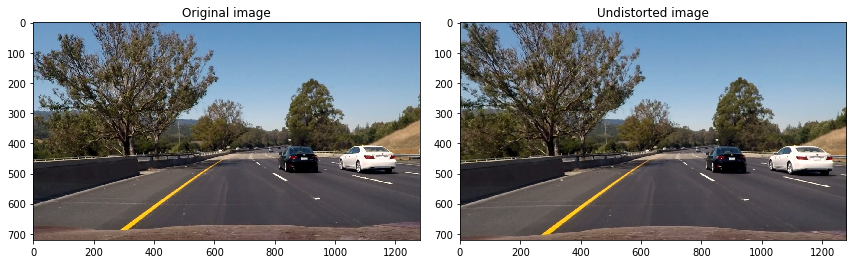

In [6]:
def image_undistort(image, mtx, dist):
    """
    Undistort an image given the camera matrix and the distortion coefficients.
    Return the undistorted image.
    """
    return cv2.undistort(image, mtx, dist)


# Undistort images
undist_images = []
test_images = glob.glob('test_images/*.jpg')
for filename in test_images:
    image = mpimg.imread(filename)
    undist_image = image_undistort(image, mtx, dist)
    undist_images.append(undist_image)
    plot_images(image, undist_image, 'Original image', 'Undistorted image')

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Gradient thresholding of an image either along the x axis or along the y axis.
    Return a binary image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x': 
        dx, dy = 1, 0
    else:
        dx, dy = 0, 1
    sobel_der = cv2.Sobel(gray, cv2.CV_64F, dx, dy)
    abs_sobel = np.absolute(sobel_der)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Gradient magnitude thresholding of an image (along both axis). 
    Return a binary image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scale_factor = np.max(abs_sobelxy)/255 
    gradmag = (abs_sobelxy/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Gradient direction thresholding of an image.
    Return a binary image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx) 
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary


def hls_s_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S < thresh[1])] = 1
    return binary

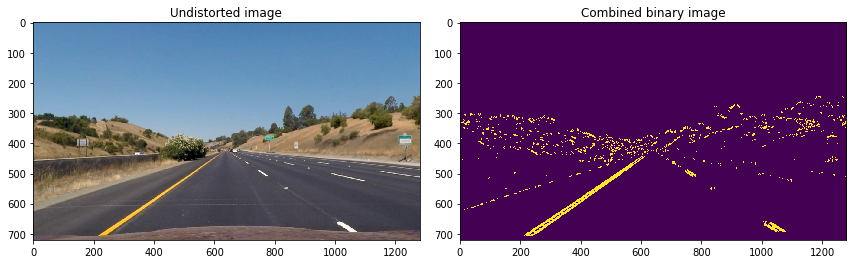

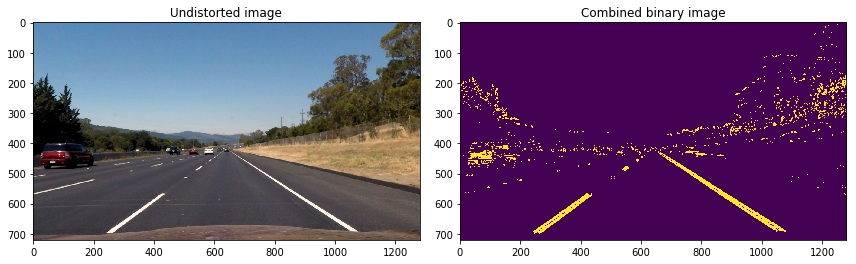

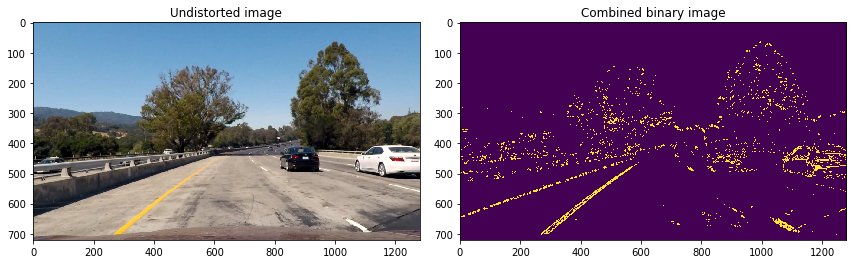

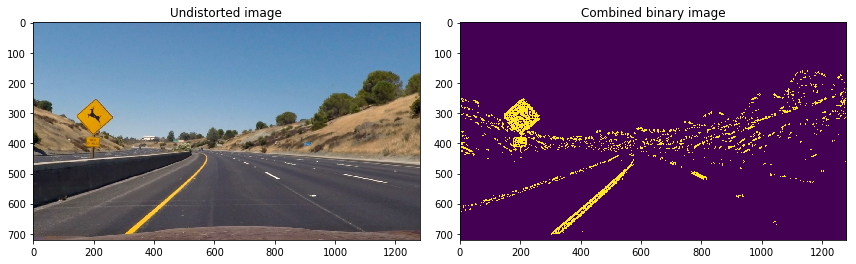

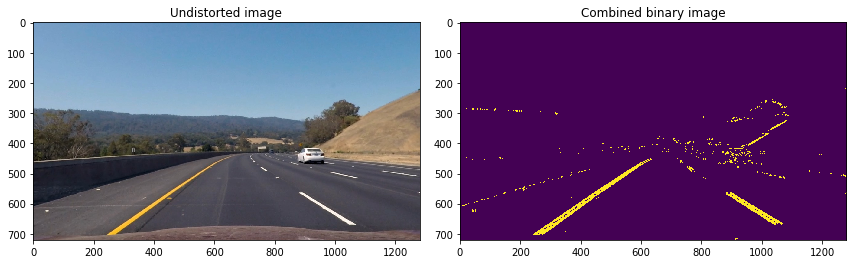

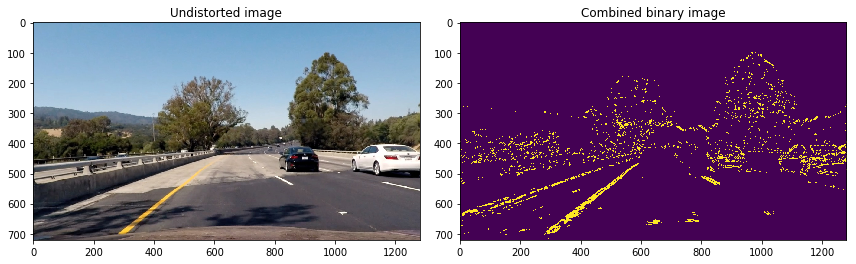

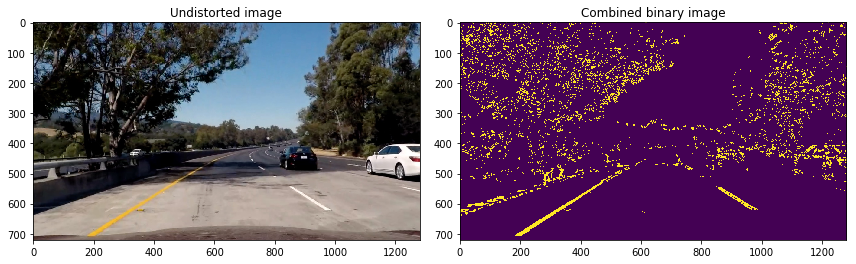

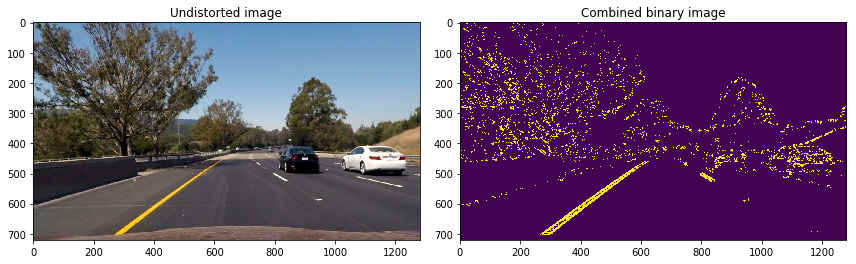

In [8]:
def image_filter(image):
    """
    Apply different gradient thresholding techniques to the image.
    Return a binary image.
    """
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.75, 1.25))
    s_binary = hls_s_thresh(image, thresh=(150, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | (s_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

# Choose a Sobel kernel size
ksize = 19 # Choose a larger odd number to smooth gradient measurements

# Binary images
bin_images = []
for image in undist_images:
    combined = image_filter(image)
    bin_images.append(combined)
    plot_images(image, combined, 'Undistorted image', 'Combined binary image')

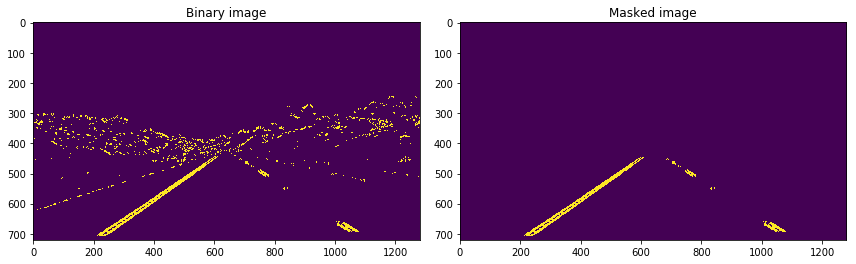

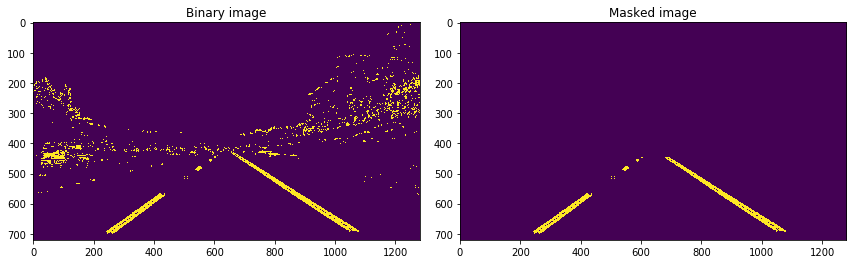

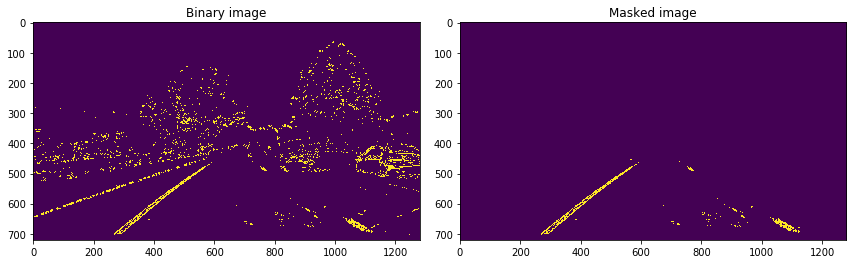

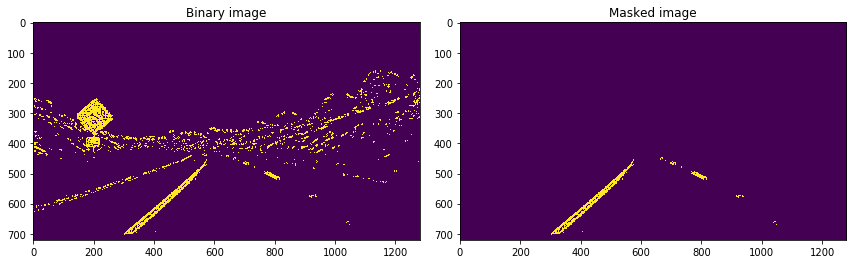

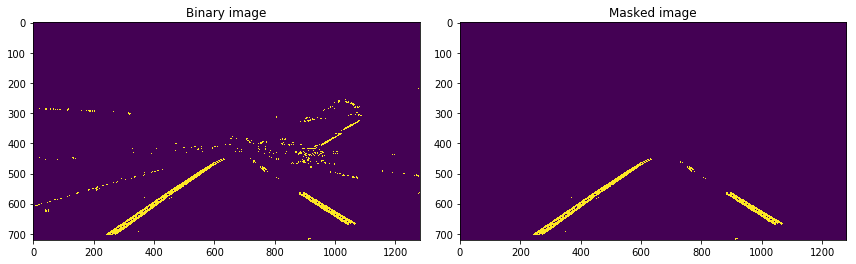

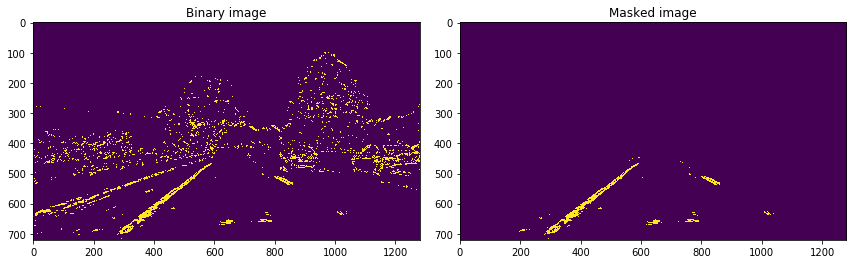

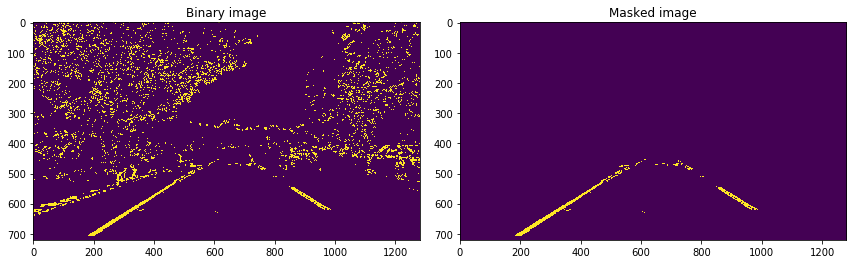

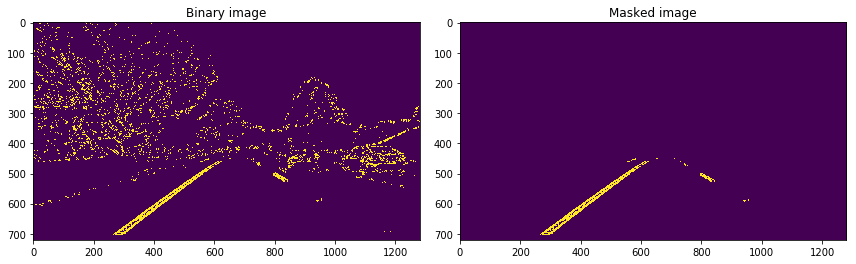

In [9]:
def region_of_interest(image, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def image_mask(image):
    """
    Mask an image isolating a region of the image delimited by a trapezoid.
    Return th masked image.
    """
    ysize = image.shape[0]
    xsize = image.shape[1]
    y_bottom = ysize
    y_top = ysize - 0.38 * ysize
    left_bottom = [xsize - 0.89 * xsize, ysize]
    right_bottom = [xsize - 0.06 * xsize, ysize]
    left_top = [xsize - 0.55 * xsize, y_top]
    right_top = [xsize - 0.45 * xsize, y_top]
    vertices = np.array([left_bottom, left_top, right_top, right_bottom])
    return region_of_interest(image, np.int32([vertices]))

masked_images = []
for image in bin_images:
    masked_image = image_mask(image)
    masked_images.append(masked_image)
    plot_images(image, masked_image, 'Binary image', 'Masked image')

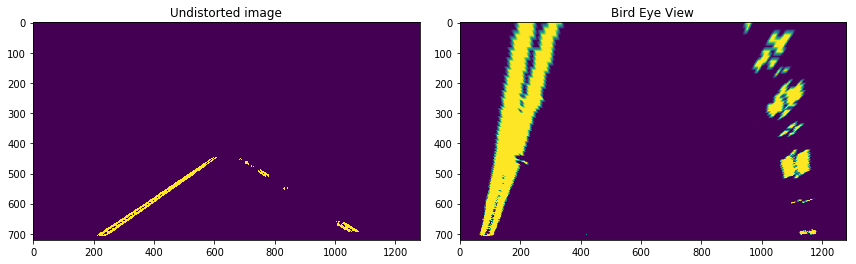

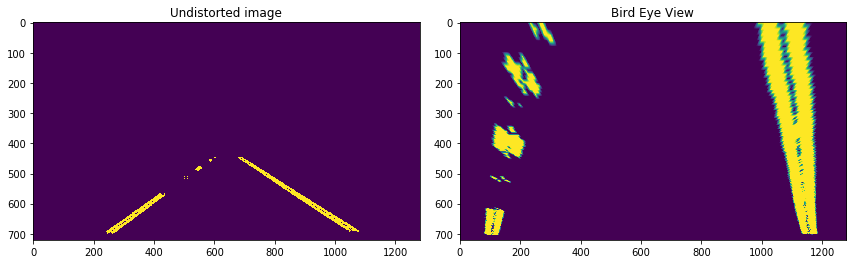

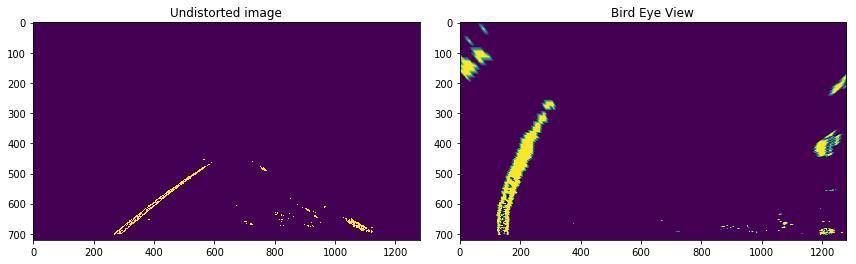

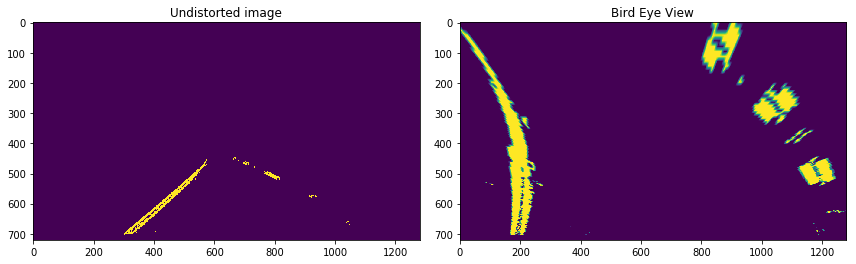

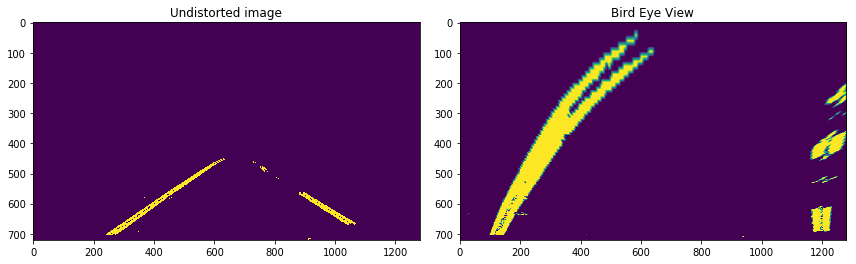

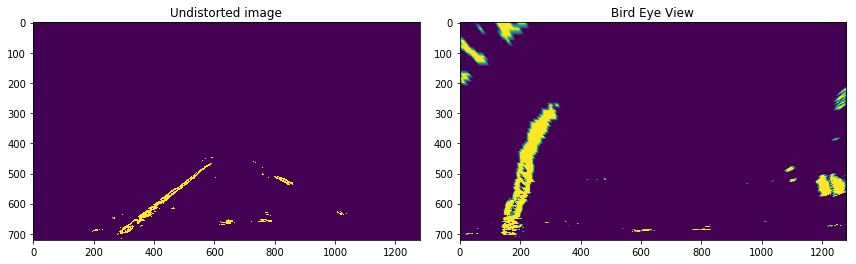

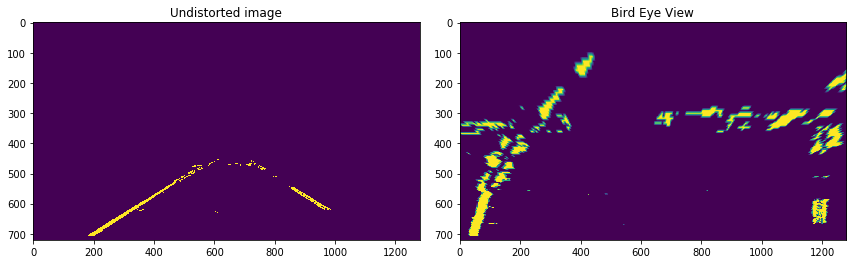

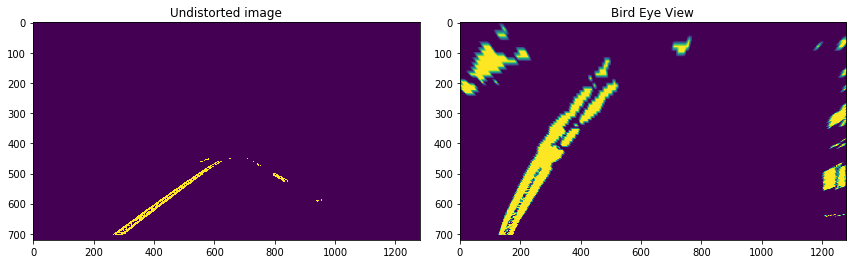

In [10]:
def image_transform(image, offset=10):
    """
    Apply perspective transformation to an image to get a Bird's Eye View.
    Return Bird's Eye View, M and Minv.
    """
    ysize = image.shape[0]
    xsize = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    y_bottom = ysize
    y_top = ysize - 0.38 * ysize
    left_bottom = [xsize - 0.89 * xsize, ysize]
    right_bottom = [xsize - 0.06 * xsize, ysize]
    left_top = [xsize - 0.55 * xsize, y_top]
    right_top = [xsize - 0.45 * xsize, y_top]
    src = np.array([[left_top, right_top, right_bottom, left_bottom]]).astype(np.float32)
    dst = np.float32([[offset, offset],
                      [image.shape[1] - offset, offset],
                      [image.shape[1] - offset, image.shape[0] - offset],
                      [offset, image.shape[0] - offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(src, dst)
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv

for image in masked_images:
    warped_image, M, Minv = image_transform(image)
    plot_images(image, warped_image, 'Undistorted image', 'Bird Eye View')

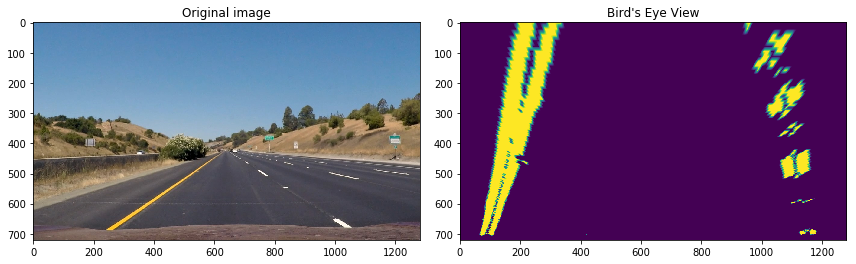

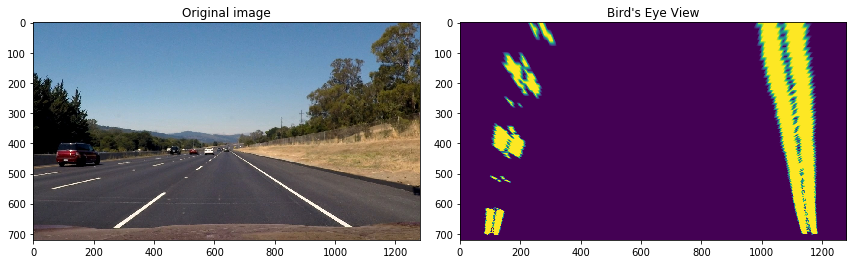

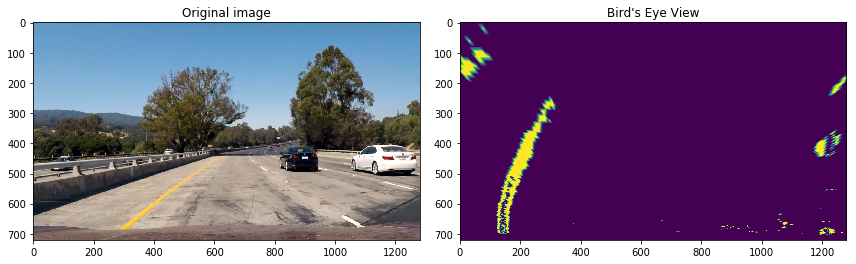

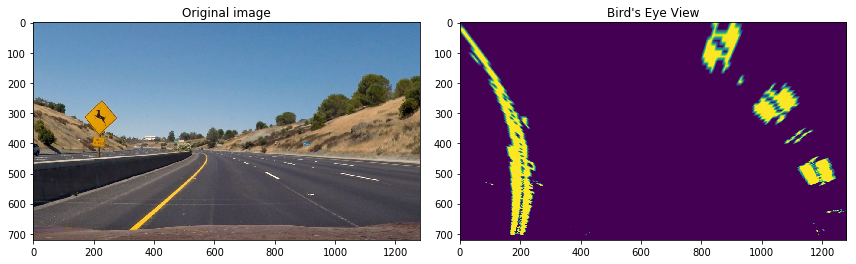

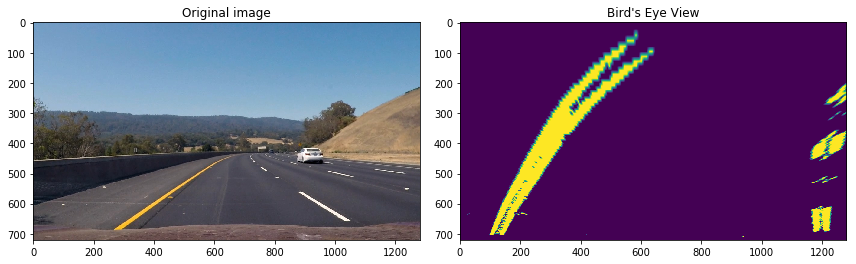

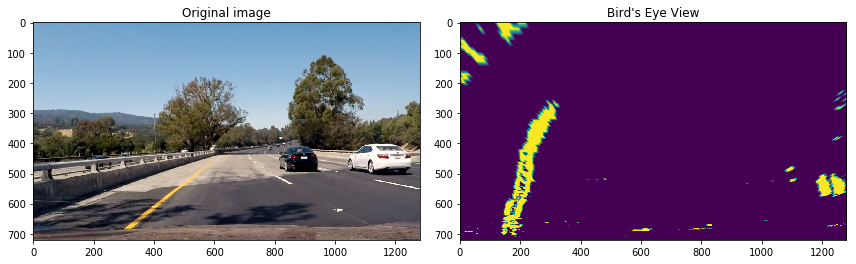

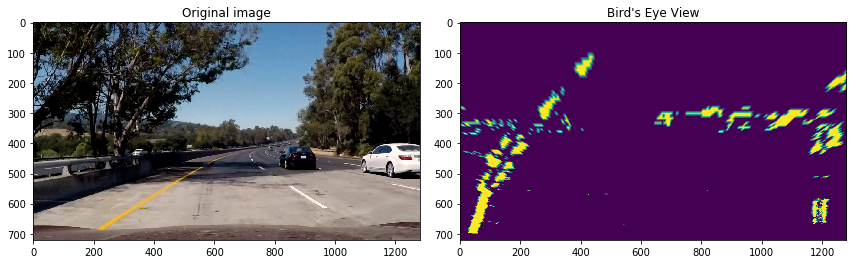

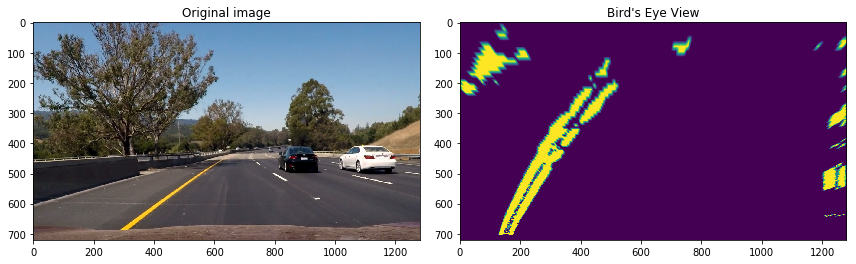

In [11]:
# Apply the full pipeline to each image
def pipeline(image, mtx, dist):
    """
    Apply the full pipeline to an image.
    Return the Bird's Eye View image.
    """
    # Undistort the original image
    undist_image = image_undistort(image, mtx, dist)
    # Apply gradient and color thresholding
    filtered_image = image_filter(undist_image)
    # Isolate the region of interest
    masked_image = image_mask(filtered_image)
    # Apply perspective transformation
    transformed_image, M, Minv = image_transform(masked_image)
    return transformed_image, M, Minv

test_images = glob.glob('test_images/*.jpg')
for filename in test_images:
    image = mpimg.imread(filename)
    bird_image, M , Minv = pipeline(image, mtx, dist)
    plot_images(image, bird_image, 'Original image', 'Bird\'s Eye View')
